In [1]:
import pandas as pd
from rdkit import Chem

def prepare_data():
    df_main = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\init_data\pKa_Prediction_Starting data_2024.01.25.csv', index_col=0)
    df_main = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\init_data\pKa_Prediction_Starting data_2024.05.07.csv', index_col=0)

    SMILES_to_fgroup = {}
    SMILES_to_identificator = {}
    SMILES_to_cycle_type = {}
    SMILES_to_logP = {}
    for index, row in df_main.iterrows():
        SMILES = row['Amides for LogP']
        if pd.isnull(SMILES):
            continue
        
        SMILES_to_fgroup[SMILES] = row['F group']
        SMILES_to_identificator[SMILES] = row['identificator']
        SMILES_to_cycle_type[SMILES] = row['Framework']
        SMILES_to_logP[SMILES] = row['LogP']
    
    return SMILES_to_fgroup, SMILES_to_identificator, SMILES_to_cycle_type, SMILES_to_logP

def train_test_smiles_data(is_canon=True):
    train = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\logP_lipophilicity_data\gnn_cv\train.csv')
    test = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\logP_lipophilicity_data\gnn_cv\test.csv')

    train_SMILES = train['Smiles'].tolist()
    test_SMILES = test['Smiles'].tolist()

    if is_canon:
        for train_index in range(len(train_SMILES)):
            train_SMILES[train_index] = Chem.CanonSmiles(train_SMILES[train_index])
        for test_index in range(len(test_SMILES)):
            test_SMILES[test_index] = Chem.CanonSmiles(test_SMILES[test_index])
    
    return train_SMILES, test_SMILES

In [2]:
"""average atom relevance in fluorine group with hydrogens, scaled"""
# relevances_fluorine = {'CCC(F)(F)CC(=O)NC1=CC=CC=C1': 0.04, 'FC(F)CCCC(=O)NC1=CC=CC=C1': -0.04, 'CCCCC(=O)NC1=CC=CC=C1': 0, 'FC(F)(F)C12CC(C1)CN2C(=O)C1=CC=CC=C1': 0.7, 'FC(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.6, 'O=C(N1CC2CC1C2)C1=CC=CC=C1': 0, 'O=C(N1CCCC1)C1=CC=CC=C1': 0, 'CC12CC(C1)CN2C(=O)C1=CC=CC=C1': 0, 'FC(F)(F)C12CCC(CN1C(=O)C1=CC=CC=C1)C2': 0.59, 'FC(F)(F)C12CCC(CC1)CN2C(=O)C1=CC=CC=C1': 0.69, 'FC(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.6, 'O=C(N1CC2CCC1C2)C1=CC=CC=C1': 0, 'CC12CCC(CC1)CN2C(=O)C1=CC=CC=C1': 0, 'O=C(N1CC2CCC1CC2)C1=CC=CC=C1': 0, 'O=C(N1CCCCC1)C1=CC=CC=C1': 0, 'FC(F)(F)C12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0.58, 'O=C(N1CC2CC1CCC2)C1=CC=CC=C1': 0, 'CC12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0, 'FC1(F)CC2CC(CN(C2)C(=O)C2=CC=CC=C2)C1': 0.81, 'FC1(F)CC2CN(CC(C1)C2(F)F)C(=O)C1=CC=CC=C1': 0.74, 'FC1(F)C2CCCC1CN(C2)C(=O)C1=CC=CC=C1': 1.0, 'FC1(F)C2COCC1CN(C2)C(=O)C1=CC=CC=C1': 1.0, 'O=C(N1CC2COCC(C2)C1)C1=CC=CC=C1': 0, 'FC1(F)C2CCC1CN(C2)C(=O)C1=CC=CC=C1': 1.0, 'O=C(N1CC2CCC(C2)C1)C1=CC=CC=C1': 0, 'O=C(N1CCC1)C1=CC=CC=C1': 0, 'FC1CN(C1)C(=O)C1=CC=CC=C1': 0.73, 'FC1CCN(C1)C(=O)C1=CC=CC=C1': 0.61, 'FC1(F)CCN(C1)C(=O)C1=CC=CC=C1': 0.96, 'F[C@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': 0.65, 'F[C@@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': 0.64, 'FC1CCCN(C1)C(=O)C1=CC=CC=C1': 0.47, 'FC1(F)CCCN(C1)C(=O)C1=CC=CC=C1': 0.94, 'F[C@H]1C[C@@H](F)CN(C1)C(=O)C1=CC=CC=C1': 0.7, 'F[C@H]1C[C@H](F)CN(C1)C(=O)C1=CC=CC=C1': 0.65, 'F[C@@H]1CCN(C[C@@H]1F)C(=O)C1=CC=CC=C1': 0.58, 'F[C@@H]1CCN(C[C@H]1F)C(=O)C1=CC=CC=C1': 0.55, '[H]C(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.3, '[H]C([H])(F)C1CCCCN1C(=O)C1=CC=CC=C1': -0.5, '[H]C(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.27, '[H]C([H])(F)C1CCCN1C(=O)C1=CC=CC=C1': -0.55, 'FC(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.53, '[H]C(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.15, '[H]C([H])(F)C1CCN1C(=O)C1=CC=CC=C1': -0.53, '[H]C(F)(F)CNC(=O)C1=CC=CC=C1': 0.28, 'FC(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.59, '[H]C(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.42, '[H]C([H])(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.34, 'FC(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.6, '[H]C(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.39, 'FC(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.49, '[H]C(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.33, '[H]C([H])(F)C1CN(C1)C(=O)C1=CC=CC=C1': -0.24, '[H]C(F)(F)CCNC(=O)C1=CC=CC=C1': 0.06, '[H]C([H])(F)CCNC(=O)C1=CC=CC=C1': -0.42, 'CCNC(=O)C1=CC=CC=C1': 0, 'FC(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': 0.54, '[H]C([H])(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': -0.15, '[H]C([H])(F)CCCNC(=O)C1=CC=CC=C1': -0.46, '[H]C(F)(F)CCCNC(=O)C1=CC=CC=C1': -0.06, 'FC(F)(F)CCCNC(=O)C1=CC=CC=C1': 0.44, 'CCCNC(=O)C1=CC=CC=C1': 0, 'CCC(F)(F)CNC(=O)C1=CC=CC=C1': -0.1, 'CC(F)(F)CCNC(=O)C1=CC=CC=C1': 0.69, 'FC(F)CCCNC(=O)C1=CC=CC=C1': -0.06, 'CCCCNC(=O)C1=CC=CC=C1': 0, 'FC1CCN(CC1)C(=O)C1=CC=CC=C1': 0.79, 'O=C(N1CC2CCCC(C2)C1)C1=CC=CC=C1': 0, 'FC1(F)CCN(CC1)C(=O)C1=CC=CC=C1': 1.0, '[H]C(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': 0.25, 'FC(F)(F)CCNC(=O)C1=CC=CC=C1': 0.46, '[H]C([H])(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.34, 'FC1(F)CN(C1)C(=O)C1=CC=CC=C1': 0.95, '[H]C([H])(F)CNC(=O)C1=CC=CC=C1': -0.3, 'CC(F)(F)CCC(=O)NC1=CC=CC=C1': 0.65}

# cyclobutane = {1: {'H': [0.18]}, 2: {'H': [0.53]}}
# cyclopentane = {1: {'H': [0.27]}, 2: {'H': [0.62]}}
# cyclohexan = {1: {'H': [0.14]}, 2: {'H': [0.53]}, 3: {'H': [0.58]}}
# methane = {1: {'H': [0.68], 'CF3': [0.73]}, 2: {'H': [0.18]}, 3: {'H': [-0.17]}}

"""atom sum in fluorine group withour hydrogens, not scaled"""
# relevances_fluorine = {'CCC(F)(F)CC(=O)NC1=CC=CC=C1': 0.05, 'FC(F)CCCC(=O)NC1=CC=CC=C1': -0.02, 'CCCCC(=O)NC1=CC=CC=C1': 0, 'FC(F)(F)C12CC(C1)CN2C(=O)C1=CC=CC=C1': 0.39, 'FC(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.61, 'O=C(N1CC2CC1C2)C1=CC=CC=C1': 0, 'O=C(N1CCCC1)C1=CC=CC=C1': 0, 'CC12CC(C1)CN2C(=O)C1=CC=CC=C1': 0, 'FC(F)(F)C12CCC(CN1C(=O)C1=CC=CC=C1)C2': 0.34, 'FC(F)(F)C12CCC(CC1)CN2C(=O)C1=CC=CC=C1': 0.39, 'FC(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.61, 'O=C(N1CC2CCC1C2)C1=CC=CC=C1': 0, 'CC12CCC(CC1)CN2C(=O)C1=CC=CC=C1': 0, 'O=C(N1CC2CCC1CC2)C1=CC=CC=C1': 0, 'O=C(N1CCCCC1)C1=CC=CC=C1': 0, 'FC(F)(F)C12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0.34, 'O=C(N1CC2CC1CCC2)C1=CC=CC=C1': 0, 'CC12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0, 'FC1(F)CC2CC(CN(C2)C(=O)C2=CC=CC=C2)C1': -0.12, 'FC1(F)CC2CN(CC(C1)C2(F)F)C(=O)C1=CC=CC=C1': -0.24, 'FC1(F)C2CCCC1CN(C2)C(=O)C1=CC=CC=C1': -0.22, 'FC1(F)C2COCC1CN(C2)C(=O)C1=CC=CC=C1': -0.01, 'O=C(N1CC2COCC(C2)C1)C1=CC=CC=C1': 0, 'FC1(F)C2CCC1CN(C2)C(=O)C1=CC=CC=C1': -0.22, 'O=C(N1CC2CCC(C2)C1)C1=CC=CC=C1': 0, 'O=C(N1CCC1)C1=CC=CC=C1': 0, 'FC1CN(C1)C(=O)C1=CC=CC=C1': -0.1, 'FC1CCN(C1)C(=O)C1=CC=CC=C1': -0.21, 'FC1(F)CCN(C1)C(=O)C1=CC=CC=C1': 0.21, 'F[C@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': 0.14, 'F[C@@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': -0.01, 'FC1CCCN(C1)C(=O)C1=CC=CC=C1': -0.24, 'FC1(F)CCCN(C1)C(=O)C1=CC=CC=C1': 0.03, 'F[C@H]1C[C@@H](F)CN(C1)C(=O)C1=CC=CC=C1': 0.11, 'F[C@H]1C[C@H](F)CN(C1)C(=O)C1=CC=CC=C1': 0.64, 'F[C@@H]1CCN(C[C@@H]1F)C(=O)C1=CC=CC=C1': 0.17, 'F[C@@H]1CCN(C[C@H]1F)C(=O)C1=CC=CC=C1': 0.06, '[H]C(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.2, '[H]C([H])(F)C1CCCCN1C(=O)C1=CC=CC=C1': -0.08, '[H]C(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.16, '[H]C([H])(F)C1CCCN1C(=O)C1=CC=CC=C1': -0.14, 'FC(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.61, '[H]C(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.19, '[H]C([H])(F)C1CCN1C(=O)C1=CC=CC=C1': -0.06, '[H]C(F)(F)CNC(=O)C1=CC=CC=C1': 0.26, 'FC(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.68, '[H]C(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.2, '[H]C([H])(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': -0.21, 'FC(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.66, '[H]C(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.2, 'FC(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.67, '[H]C(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.26, '[H]C([H])(F)C1CN(C1)C(=O)C1=CC=CC=C1': -0.09, '[H]C(F)(F)CCNC(=O)C1=CC=CC=C1': 0.15, '[H]C([H])(F)CCNC(=O)C1=CC=CC=C1': -0.19, 'CCNC(=O)C1=CC=CC=C1': 0, 'FC(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': 0.45, '[H]C([H])(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': -0.05, '[H]C([H])(F)CCCNC(=O)C1=CC=CC=C1': -0.15, '[H]C(F)(F)CCCNC(=O)C1=CC=CC=C1': -0.03, 'FC(F)(F)CCCNC(=O)C1=CC=CC=C1': 0.28, 'CCCNC(=O)C1=CC=CC=C1': 0, 'CCC(F)(F)CNC(=O)C1=CC=CC=C1': 0.05, 'CC(F)(F)CCNC(=O)C1=CC=CC=C1': -0.15, 'FC(F)CCCNC(=O)C1=CC=CC=C1': -0.03, 'CCCCNC(=O)C1=CC=CC=C1': 0, 'FC1CCN(CC1)C(=O)C1=CC=CC=C1': -0.13, 'O=C(N1CC2CCCC(C2)C1)C1=CC=CC=C1': 0, 'FC1(F)CCN(CC1)C(=O)C1=CC=CC=C1': 0.14, '[H]C(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': 0.12, 'FC(F)(F)CCNC(=O)C1=CC=CC=C1': 0.44, '[H]C([H])(F)C1CCN(C1)C(=O)C1=CC=CC=C1': -0.23, 'FC1(F)CN(C1)C(=O)C1=CC=CC=C1': 0.14, '[H]C([H])(F)CNC(=O)C1=CC=CC=C1': -0.12, 'CC(F)(F)CCC(=O)NC1=CC=CC=C1': -0.04}

# cyclobutane = {1: {'H': [0.06]}, 2: {'H': [0.16]}} # logP_O=C(N1CCC1)C1=CC=CC=C1
# cyclopentane = {1: {'H': [0.01]}, 2: {'H': [0.09]}} #  logP_O=C(N1CCCC1)C1=CC=CC=C1
# cyclohexan = {1: {'H': [0.02]}, 2: {'H': [0.06]}, 3: {'H': [0.05]}} # logP_O=C(N1CCCCC1)C1=CC=CC=C1
# methane = {1: {'CF3': [0.43]}, 2: {'H': [0.56]}, 3: {'H': [0.33]}} # 1: CNC(=O)C1=CC=CC=C1, 2: CCNC(=O)C1=CC=CC=C1 , 3: CCCNC(=O)C1=CC=CC=C1

"""atom average relevance in fluorine group withour hydrogens, not scaled"""
# relevances_fluorine = {'CCC(F)(F)CC(=O)NC1=CC=CC=C1': 0.03, 'FC(F)CCCC(=O)NC1=CC=CC=C1': -0.01, 'CCCCC(=O)NC1=CC=CC=C1': 0, 'FC(F)(F)C12CC(C1)CN2C(=O)C1=CC=CC=C1': 0.1, 'FC(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.15, 'O=C(N1CC2CC1C2)C1=CC=CC=C1': 0, 'O=C(N1CCCC1)C1=CC=CC=C1': 0, 'CC12CC(C1)CN2C(=O)C1=CC=CC=C1': 0, 'FC(F)(F)C12CCC(CN1C(=O)C1=CC=CC=C1)C2': 0.08, 'FC(F)(F)C12CCC(CC1)CN2C(=O)C1=CC=CC=C1': 0.1, 'FC(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.15, 'O=C(N1CC2CCC1C2)C1=CC=CC=C1': 0, 'CC12CCC(CC1)CN2C(=O)C1=CC=CC=C1': 0, 'O=C(N1CC2CCC1CC2)C1=CC=CC=C1': 0, 'O=C(N1CCCCC1)C1=CC=CC=C1': 0, 'FC(F)(F)C12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0.08, 'O=C(N1CC2CC1CCC2)C1=CC=CC=C1': 0, 'CC12CC(CN1C(=O)C1=CC=CC=C1)CCC2': 0, 'FC1(F)CC2CC(CN(C2)C(=O)C2=CC=CC=C2)C1': -0.06, 'FC1(F)CC2CN(CC(C1)C2(F)F)C(=O)C1=CC=CC=C1': -0.06, 'FC1(F)C2CCCC1CN(C2)C(=O)C1=CC=CC=C1': -0.11, 'FC1(F)C2COCC1CN(C2)C(=O)C1=CC=CC=C1': -0.01, 'O=C(N1CC2COCC(C2)C1)C1=CC=CC=C1': 0, 'FC1(F)C2CCC1CN(C2)C(=O)C1=CC=CC=C1': -0.11, 'O=C(N1CC2CCC(C2)C1)C1=CC=CC=C1': 0, 'O=C(N1CCC1)C1=CC=CC=C1': 0, 'FC1CN(C1)C(=O)C1=CC=CC=C1': -0.05, 'FC1CCN(C1)C(=O)C1=CC=CC=C1': -0.11, 'FC1(F)CCN(C1)C(=O)C1=CC=CC=C1': 0.1, 'F[C@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': 0.03, 'F[C@@H]1CN(C[C@H]1F)C(=O)C1=CC=CC=C1': -0.0, 'FC1CCCN(C1)C(=O)C1=CC=CC=C1': -0.12, 'FC1(F)CCCN(C1)C(=O)C1=CC=CC=C1': 0.02, 'F[C@H]1C[C@@H](F)CN(C1)C(=O)C1=CC=CC=C1': 0.03, 'F[C@H]1C[C@H](F)CN(C1)C(=O)C1=CC=CC=C1': 0.16, 'F[C@@H]1CCN(C[C@@H]1F)C(=O)C1=CC=CC=C1': 0.04, 'F[C@@H]1CCN(C[C@H]1F)C(=O)C1=CC=CC=C1': 0.02, '[H]C(F)(F)C1CCCCN1C(=O)C1=CC=CC=C1': 0.07, '[H]C([H])(F)C1CCCCN1C(=O)C1=CC=CC=C1': -0.04, '[H]C(F)(F)C1CCCN1C(=O)C1=CC=CC=C1': 0.05, '[H]C([H])(F)C1CCCN1C(=O)C1=CC=CC=C1': -0.07, 'FC(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.15, '[H]C(F)(F)C1CCN1C(=O)C1=CC=CC=C1': 0.06, '[H]C([H])(F)C1CCN1C(=O)C1=CC=CC=C1': -0.03, '[H]C(F)(F)CNC(=O)C1=CC=CC=C1': 0.09, 'FC(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.17, '[H]C(F)(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': 0.07, '[H]C([H])(F)C1CCCN(C1)C(=O)C1=CC=CC=C1': -0.11, 'FC(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.17, '[H]C(F)(F)C1CCN(C1)C(=O)C1=CC=CC=C1': 0.07, 'FC(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.17, '[H]C(F)(F)C1CN(C1)C(=O)C1=CC=CC=C1': 0.09, '[H]C([H])(F)C1CN(C1)C(=O)C1=CC=CC=C1': -0.05, '[H]C(F)(F)CCNC(=O)C1=CC=CC=C1': 0.05, '[H]C([H])(F)CCNC(=O)C1=CC=CC=C1': -0.1, 'CCNC(=O)C1=CC=CC=C1': 0, 'FC(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': 0.11, '[H]C([H])(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': -0.02, '[H]C([H])(F)CCCNC(=O)C1=CC=CC=C1': -0.07, '[H]C(F)(F)CCCNC(=O)C1=CC=CC=C1': -0.01, 'FC(F)(F)CCCNC(=O)C1=CC=CC=C1': 0.07, 'CCCNC(=O)C1=CC=CC=C1': 0, 'CCC(F)(F)CNC(=O)C1=CC=CC=C1': 0.03, 'CC(F)(F)CCNC(=O)C1=CC=CC=C1': -0.07, 'FC(F)CCCNC(=O)C1=CC=CC=C1': -0.01, 'CCCCNC(=O)C1=CC=CC=C1': 0, 'FC1CCN(CC1)C(=O)C1=CC=CC=C1': -0.06, 'O=C(N1CC2CCCC(C2)C1)C1=CC=CC=C1': 0, 'FC1(F)CCN(CC1)C(=O)C1=CC=CC=C1': 0.07, '[H]C(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1': 0.04, 'FC(F)(F)CCNC(=O)C1=CC=CC=C1': 0.11, '[H]C([H])(F)C1CCN(C1)C(=O)C1=CC=CC=C1': -0.11, 'FC1(F)CN(C1)C(=O)C1=CC=CC=C1': 0.07, '[H]C([H])(F)CNC(=O)C1=CC=CC=C1': -0.06, 'CC(F)(F)CCC(=O)NC1=CC=CC=C1': -0.02}

# cyclobutane = {1: {'H': [0.06]}, 2: {'H': [0.16]}} # logP_O=C(N1CCC1)C1=CC=CC=C1
# cyclopentane = {1: {'H': [0.01]}, 2: {'H': [0.09]}} #  logP_O=C(N1CCCC1)C1=CC=CC=C1
# cyclohexan = {1: {'H': [0.02]}, 2: {'H': [0.06]}, 3: {'H': [0.05]}} # logP_O=C(N1CCCCC1)C1=CC=CC=C1
# methane = {1: {'CF3': [0.09]}, 2: {'H': [0.56]}, 3: {'H': [0.33]}} # 1: CNC(=O)C1=CC=CC=C1, 2: CCNC(=O)C1=CC=CC=C1 , 3: CCCNC(=O)C1=CC=CC=C1

"""atom average relevance in fluorine group withour hydrogens, not scaled"""
# relevances_fluorine = {'CCC(F)(F)CC(=O)Nc1ccccc1': 0.05, 'CC(F)(F)CCC(=O)Nc1ccccc1': 0.02, 'O=C(CCCC(F)F)Nc1ccccc1': 0.03, 'CCCCC(=O)Nc1ccccc1': 0, 'O=C(c1ccccc1)N1CC2CC1(C(F)(F)F)C2': 0.06, 'O=C(c1ccccc1)N1CCCC1C(F)(F)F': 0.1, 'O=C(c1ccccc1)N1CC2CC1C2': 0, 'O=C(c1ccccc1)N1CCCC1': 0, 'CC12CC(CN1C(=O)c1ccccc1)C2': 0, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)C2': 0.07, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)CC2': 0.05, 'O=C(c1ccccc1)N1CCCCC1C(F)(F)F': 0.11, 'O=C(c1ccccc1)N1CC2CCC1C2': 0, 'CC12CCC(CC1)CN2C(=O)c1ccccc1': 0, 'O=C(c1ccccc1)N1CC2CCC1CC2': 0, 'O=C(c1ccccc1)N1CCCCC1': 0, 'O=C(c1ccccc1)N1CC2CCCC1(C(F)(F)F)C2': 0.05, 'O=C(c1ccccc1)N1CC2CCCC1C2': 0, 'CC12CCCC(CN1C(=O)c1ccccc1)C2': 0, 'O=C(c1ccccc1)N1CC2CC(C1)CC(F)(F)C2': 0.04, 'O=C(c1ccccc1)N1CC2CC(F)(F)CC(C1)C2(F)F': 0.03, 'O=C(c1ccccc1)N1CC2CCCC(C1)C2(F)F': 0.04, 'O=C(c1ccccc1)N1CC2CCCC(C2)C1': 0, 'O=C(c1ccccc1)N1CC2COCC(C1)C2(F)F': 0.14, 'O=C(c1ccccc1)N1CC2COCC(C2)C1': 0, 'O=C(c1ccccc1)N1CC2CC(C1)CS(=O)(=O)C2': 0, 'O=C(c1ccccc1)N1CC2CS(=O)(=O)CC(C1)C2(F)F': 0.14, 'O=C(c1ccccc1)N1CC2CCC(C1)C2(F)F': 0.04, 'O=C(c1ccccc1)N1CC2CCC(C2)C1': 0, 'O=C(c1ccccc1)N1CCC(F)(F)CC1': 0.13, 'O=C(c1ccccc1)N1CCC1': 0, 'O=C(c1ccccc1)N1CC(F)C1': -0.02, 'O=C(c1ccccc1)N1CC(F)(F)C1': 0.12, 'O=C(c1ccccc1)N1CCC(F)C1': -0.07, 'O=C(c1ccccc1)N1CCC(F)(F)C1': 0.14, 'O=C(c1ccccc1)N1C[C@@H](F)[C@@H](F)C1': -0.02, 'O=C(c1ccccc1)N1C[C@@H](F)[C@H](F)C1': -0.02, 'O=C(c1ccccc1)N1CCCC(F)C1': -0.07, 'O=C(c1ccccc1)N1CCCC(F)(F)C1': 0.05, 'O=C(c1ccccc1)N1C[C@H](F)C[C@H](F)C1': -0.03, 'O=C(c1ccccc1)N1C[C@@H](F)C[C@H](F)C1': 0.03, 'O=C(c1ccccc1)N1CCC(F)CC1': 0.04, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@@H](F)C1': 0.01, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@H](F)C1': -0.01, 'O=C(c1ccccc1)N1CCCCC1C(F)F': 0.1, 'O=C(c1ccccc1)N1CCCCC1CF': 0.06, 'O=C(c1ccccc1)N1CCCC1C(F)F': 0.06, 'O=C(c1ccccc1)N1CCCC1CF': 0.01, 'O=C(c1ccccc1)N1CCC1C(F)(F)F': 0.11, 'O=C(c1ccccc1)N1CCC1C(F)F': 0.1, 'O=C(c1ccccc1)N1CCC1CF': 0.07, 'O=C(NCC(F)(F)F)c1ccccc1': 0.09, 'O=C(NCC(F)F)c1ccccc1': 0.03, 'O=C(NCCF)c1ccccc1': -0.06, 'CNC(=O)c1ccccc1': 0, 'O=C(c1ccccc1)N1CCCC(C(F)(F)F)C1': 0.11, 'O=C(c1ccccc1)N1CCCC(C(F)F)C1': 0.06, 'O=C(c1ccccc1)N1CCCC(CF)C1': -0.02, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)C1': 0.13, 'O=C(c1ccccc1)N1CCC(C(F)F)C1': 0.09, 'O=C(c1ccccc1)N1CCC(CF)C1': 0.05, 'O=C(c1ccccc1)N1CC(C(F)(F)F)C1': 0.11, 'O=C(c1ccccc1)N1CC(C(F)F)C1': 0.06, 'O=C(c1ccccc1)N1CC(CF)C1': -0.07, 'O=C(NCCC(F)(F)F)c1ccccc1': 0.09, 'O=C(NCCC(F)F)c1ccccc1': 0.05, 'O=C(NCCCF)c1ccccc1': 0.07, 'CCNC(=O)c1ccccc1': 0, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)CC1': 0.09, 'O=C(c1ccccc1)N1CCC(C(F)F)CC1': 0.04, 'O=C(c1ccccc1)N1CCC(CF)CC1': -0.07, 'O=C(NCCCCF)c1ccccc1': 0.01, 'O=C(NCCCC(F)F)c1ccccc1': 0.05, 'O=C(NCCCC(F)(F)F)c1ccccc1': 0.07, 'CCCNC(=O)c1ccccc1': 0, 'CCC(F)(F)CNC(=O)c1ccccc1': 0.09, 'CC(F)(F)CCNC(=O)c1ccccc1': -0.01, 'CCCCNC(=O)c1ccccc1': 0}

# cyclobutane = {1: {'H': [0.06]}, 2: {'H': [0.16]}} # logP_O=C(N1CCC1)C1=CC=CC=C1
# cyclopentane = {1: {'H': [0.01]}, 2: {'H': [0.09]}} #  logP_O=C(N1CCCC1)C1=CC=CC=C1
# cyclohexan = {1: {'H': [0.02]}, 2: {'H': [0.06]}, 3: {'H': [0.05]}} # logP_O=C(N1CCCCC1)C1=CC=CC=C1
# methane = {1: {'H': [0.12], 'CF3': [0.10]}, 2: {'H': [0.56]}, 3: {'H': [0.33]}} # 1: CNC(=O)C1=CC=CC=C1, 2: CCNC(=O)C1=CC=CC=C1 , 3: CCCNC(=O)C1=CC=CC=C1

"""atom sum relevance in fluorine group withour hydrogens, not scaled"""
# relevances_fluorine = {'O=C(c1ccccc1)N1CC2CC1(C(F)(F)F)C2': 0.301, 'O=C(c1ccccc1)N1CCCC1C(F)(F)F': 0.484, 'O=C(c1ccccc1)N1CC2CC1C2': 0, 'O=C(c1ccccc1)N1CCCC1': 0, 'CC12CC(CN1C(=O)c1ccccc1)C2': 0, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)C2': 0.333, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)CC2': 0.228, 'O=C(c1ccccc1)N1CCCCC1C(F)(F)F': 0.546, 'O=C(c1ccccc1)N1CC2CCC1C2': 0, 'CC12CCC(CC1)CN2C(=O)c1ccccc1': 0, 'O=C(c1ccccc1)N1CC2CCC1CC2': 0, 'O=C(c1ccccc1)N1CCCCC1': 0, 'O=C(c1ccccc1)N1CC2CCCC1(C(F)(F)F)C2': 0.263, 'O=C(c1ccccc1)N1CC2CCCC1C2': 0, 'CC12CCCC(CN1C(=O)c1ccccc1)C2': 0, 'O=C(c1ccccc1)N1CC2CC(C1)CC(F)(F)C2': 0.067, 'O=C(c1ccccc1)N1CC2CC(F)(F)CC(C1)C2(F)F': 0.052, 'O=C(c1ccccc1)N1CC2CCCC(C1)C2(F)F': 0.066, 'O=C(c1ccccc1)N1CC2CCCC(C2)C1': 0, 'O=C(c1ccccc1)N1CC2COCC(C1)C2(F)F': 0.203, 'O=C(c1ccccc1)N1CC2COCC(C2)C1': 0, 'O=C(c1ccccc1)N1CC2CC(C1)CS(=O)(=O)C2': 0, 'O=C(c1ccccc1)N1CC2CS(=O)(=O)CC(C1)C2(F)F': 0.214, 'O=C(c1ccccc1)N1CC2CCC(C1)C2(F)F': 0.062, 'O=C(c1ccccc1)N1CC2CCC(C2)C1': 0, 'O=C(c1ccccc1)N1CCC(F)(F)CC1': 0.202, 'O=C(c1ccccc1)N1CCC1': 0, 'O=C(c1ccccc1)N1CC(F)C1': -0.04, 'O=C(c1ccccc1)N1CC(F)(F)C1': 0.177, 'O=C(c1ccccc1)N1CCC(F)C1': -0.148, 'O=C(c1ccccc1)N1CCC(F)(F)C1': 0.211, 'O=C(c1ccccc1)N1C[C@@H](F)[C@@H](F)C1': -0.028, 'O=C(c1ccccc1)N1C[C@@H](F)[C@H](F)C1': -0.037, 'O=C(c1ccccc1)N1CCCC(F)C1': -0.131, 'O=C(c1ccccc1)N1CCCC(F)(F)C1': 0.07, 'O=C(c1ccccc1)N1C[C@H](F)C[C@H](F)C1': -0.047, 'O=C(c1ccccc1)N1C[C@@H](F)C[C@H](F)C1': 0.058, 'O=C(c1ccccc1)N1CCC(F)CC1': 0.087, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@@H](F)C1': 0.018, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@H](F)C1': -0.008, 'O=C(c1ccccc1)N1CCCCC1C(F)F': 0.39, 'O=C(c1ccccc1)N1CCCCC1CF': 0.188, 'O=C(c1ccccc1)N1CCCC1C(F)F': 0.258, 'O=C(c1ccccc1)N1CCCC1CF': 0.037, 'O=C(c1ccccc1)N1CCC1C(F)(F)F': 0.554, 'O=C(c1ccccc1)N1CCC1C(F)F': 0.39, 'O=C(c1ccccc1)N1CCC1CF': 0.208, 'O=C(NCC(F)(F)F)c1ccccc1': 0.467, 'O=C(NCC(F)F)c1ccccc1': 0.125, 'O=C(NCCF)c1ccccc1': -0.169, 'CNC(=O)c1ccccc1': 0, 'O=C(c1ccccc1)N1CCCC(C(F)(F)F)C1': 0.538, 'O=C(c1ccccc1)N1CCCC(C(F)F)C1': 0.225, 'O=C(c1ccccc1)N1CCCC(CF)C1': -0.057, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)C1': 0.653, 'O=C(c1ccccc1)N1CCC(C(F)F)C1': 0.351, 'O=C(c1ccccc1)N1CCC(CF)C1': 0.136, 'O=C(c1ccccc1)N1CC(C(F)(F)F)C1': 0.562, 'O=C(c1ccccc1)N1CC(C(F)F)C1': 0.244, 'O=C(c1ccccc1)N1CC(CF)C1': -0.208, 'O=C(NCCC(F)(F)F)c1ccccc1': 0.431, 'O=C(NCCC(F)F)c1ccccc1': 0.186, 'O=C(NCCCF)c1ccccc1': 0.216, 'CCNC(=O)c1ccccc1': 0, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)CC1': 0.428, 'O=C(c1ccccc1)N1CCC(C(F)F)CC1': 0.176, 'O=C(c1ccccc1)N1CCC(CF)CC1': -0.216, 'O=C(NCCCCF)c1ccccc1': 0.026, 'O=C(NCCCC(F)F)c1ccccc1': 0.185, 'O=C(NCCCC(F)(F)F)c1ccccc1': 0.345, 'CCCNC(=O)c1ccccc1': 0, 'CCC(F)(F)CNC(=O)c1ccccc1': 0.132, 'CC(F)(F)CCNC(=O)c1ccccc1': -0.014, 'CCCCNC(=O)c1ccccc1': 0}

# cyclobutane = {1: {'H': [0.06]}, 2: {'H': [0.16]}} # logP_O=C(N1CCC1)C1=CC=CC=C1
# cyclopentane = {1: {'H': [0.01]}, 2: {'H': [0.09]}} #  logP_O=C(N1CCCC1)C1=CC=CC=C1
# cyclohexan = {1: {'H': [0.02]}, 2: {'H': [0.06]}, 3: {'H': [0.05]}} # logP_O=C(N1CCCCC1)C1=CC=CC=C1
# methane = {1: {'H': [0.12], 'CF3': [0.10]}, 2: {'H': [0.56]}, 3: {'H': [0.33]}} # 1: CNC(=O)C1=CC=CC=C1, 2: CCNC(=O)C1=CC=CC=C1 , 3: CCCNC(=O)C1=CC=CC=C1

"""atom sum relevance in fluorine group withour hydrogens, not scaled, SME relevance"""
# relevances_fluorine = {'CCC(F)(F)CC(=O)Nc1ccccc1': 0.026, 'CC(F)(F)CCC(=O)Nc1ccccc1': -0.022, 'O=C(CCCC(F)F)Nc1ccccc1': -0.022, 'CCCCC(=O)Nc1ccccc1': 0.3896028995513916, 'O=C(c1ccccc1)N1CC2CC1(C(F)(F)F)C2': 0.392, 'O=C(c1ccccc1)N1CCCC1C(F)(F)F': 0.611, 'O=C(c1ccccc1)N1CC2CC1C2': -0.2249714732170105, 'O=C(c1ccccc1)N1CCCC1': -0.20608405768871307, 'CC12CC(CN1C(=O)c1ccccc1)C2': 0.0604947991669178, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)C2': 0.339, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)CC2': 0.387, 'O=C(c1ccccc1)N1CCCCC1C(F)(F)F': 0.611, 'O=C(c1ccccc1)N1CC2CCC1C2': 0.25195685029029846, 'CC12CCC(CC1)CN2C(=O)c1ccccc1': 0.33386948704719543, 'O=C(c1ccccc1)N1CC2CCC1CC2': 0.020969390869140625, 'O=C(c1ccccc1)N1CCCCC1': -0.21147394180297852, 'O=C(c1ccccc1)N1CC2CCCC1(C(F)(F)F)C2': 0.337, 'O=C(c1ccccc1)N1CC2CCCC1C2': 0.37833264470100403, 'CC12CCCC(CN1C(=O)c1ccccc1)C2': 0.6401145458221436, 'O=C(c1ccccc1)N1CC2CC(C1)CC(F)(F)C2': -0.062, 'O=C(c1ccccc1)N1CC2CC(F)(F)CC(C1)C2(F)F': -0.059, 'O=C(c1ccccc1)N1CC2CCCC(C1)C2(F)F': -0.109, 'O=C(c1ccccc1)N1CC2CCCC(C2)C1': 0.24803578853607178, 'O=C(c1ccccc1)N1CC2COCC(C1)C2(F)F': -0.007, 'O=C(c1ccccc1)N1CC2COCC(C2)C1': -0.7405126094818115, 'O=C(c1ccccc1)N1CC2CC(C1)CS(=O)(=O)C2': -0.44825273752212524, 'O=C(c1ccccc1)N1CC2CS(=O)(=O)CC(C1)C2(F)F': 0.0, 'O=C(c1ccccc1)N1CC2CCC(C1)C2(F)F': -0.109, 'O=C(c1ccccc1)N1CC2CCC(C2)C1': 0.11700892448425293, 'O=C(c1ccccc1)N1CCC(F)(F)CC1': 0.072, 'O=C(c1ccccc1)N1CCC1': -0.26524823904037476, 'O=C(c1ccccc1)N1CC(F)C1': -0.108, 'O=C(c1ccccc1)N1CC(F)(F)C1': 0.069, 'O=C(c1ccccc1)N1CCC(F)C1': -0.284, 'O=C(c1ccccc1)N1CCC(F)(F)C1': 0.103, 'O=C(c1ccccc1)N1C[C@@H](F)[C@@H](F)C1': -0.004, 'O=C(c1ccccc1)N1C[C@@H](F)[C@H](F)C1': -0.034, 'O=C(c1ccccc1)N1CCCC(F)C1': -0.313, 'O=C(c1ccccc1)N1CCCC(F)(F)C1': 0.017, 'O=C(c1ccccc1)N1C[C@H](F)C[C@H](F)C1': -0.211, 'O=C(c1ccccc1)N1C[C@@H](F)C[C@H](F)C1': -0.156, 'O=C(c1ccccc1)N1CCC(F)CC1': -0.073, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@@H](F)C1': -0.111, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@H](F)C1': -0.094, 'O=C(c1ccccc1)N1CCCCC1C(F)F': 0.198, 'O=C(c1ccccc1)N1CCCCC1CF': -0.077, 'O=C(c1ccccc1)N1CCCC1C(F)F': 0.163, 'O=C(c1ccccc1)N1CCCC1CF': -0.136, 'O=C(c1ccccc1)N1CCC1C(F)(F)F': 0.611, 'O=C(c1ccccc1)N1CCC1C(F)F': 0.188, 'O=C(c1ccccc1)N1CCC1CF': -0.055, 'O=C(NCC(F)(F)F)c1ccccc1': 0.586, 'O=C(NCC(F)F)c1ccccc1': 0.264, 'O=C(NCCF)c1ccccc1': -0.117, 'CNC(=O)c1ccccc1': -0.7616559267044067, 'O=C(c1ccccc1)N1CCCC(C(F)(F)F)C1': 0.676, 'O=C(c1ccccc1)N1CCCC(C(F)F)C1': 0.205, 'O=C(c1ccccc1)N1CCCC(CF)C1': -0.212, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)C1': 0.662, 'O=C(c1ccccc1)N1CCC(C(F)F)C1': 0.205, 'O=C(c1ccccc1)N1CCC(CF)C1': -0.226, 'O=C(c1ccccc1)N1CC(C(F)(F)F)C1': 0.667, 'O=C(c1ccccc1)N1CC(C(F)F)C1': 0.257, 'O=C(c1ccccc1)N1CC(CF)C1': -0.095, 'O=C(NCCC(F)(F)F)c1ccccc1': 0.437, 'O=C(NCCC(F)F)c1ccccc1': 0.152, 'O=C(NCCCF)c1ccccc1': -0.191, 'CCNC(=O)c1ccccc1': -1.3287261724472046, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)CC1': 0.452, 'O=C(c1ccccc1)N1CCC(C(F)F)CC1': 0.116, 'O=C(c1ccccc1)N1CCC(CF)CC1': -0.049, 'O=C(NCCCCF)c1ccccc1': -0.149, 'O=C(NCCCC(F)F)c1ccccc1': -0.027, 'O=C(NCCCC(F)(F)F)c1ccccc1': 0.281, 'CCCNC(=O)c1ccccc1': 0.8204017877578735, 'CCC(F)(F)CNC(=O)c1ccccc1': 0.026, 'CC(F)(F)CCNC(=O)c1ccccc1': -0.073, 'CCCCNC(=O)c1ccccc1': 0.640187680721283}

# cyclobutane = {1: {'H': [-0.27]}, 2: {'H': [-0.27]}} # logP_O=C(N1CCC1)C1=CC=CC=C1
# cyclopentane = {1: {'H': [-0.21]}, 2: {'H': [-0.21]}} #  logP_O=C(N1CCCC1)C1=CC=CC=C1
# cyclohexan = {1: {'H': [-0.21]}, 2: {'H': [-0.21]}, 3: {'H': [-0.21]}} # logP_O=C(N1CCCCC1)C1=CC=CC=C1
# methane = {1: {'H': [0.12], 'CF3': [0.59]}, 2: {'H': [0.81]}, 3: {'H': [0.82]}} # 1: CNC(=O)C1=CC=CC=C1, 2: CCNC(=O)C1=CC=CC=C1 , 3: CCCNC(=O)C1=CC=CC=C1

"""atom sum relevance in fluorine group withour hydrogens, not scaled, SME relevance"""
# relevances_fluorine = {'CCC(F)(F)CC(=O)Nc1ccccc1': 0.152, 'CC(F)(F)CCC(=O)Nc1ccccc1': 0.042, 'O=C(CCCC(F)F)Nc1ccccc1': 0.138, 'CCCCC(=O)Nc1ccccc1': 0.3896028995513916, 'O=C(c1ccccc1)N1CC2CC1(C(F)(F)F)C2': 0.242, 'O=C(c1ccccc1)N1CCCC1C(F)(F)F': 0.459, 'O=C(c1ccccc1)N1CC2CC1C2': -0.2249714732170105, 'O=C(c1ccccc1)N1CCCC1': -0.20608405768871307, 'CC12CC(CN1C(=O)c1ccccc1)C2': 0.0604947991669178, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)C2': 0.306, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)CC2': 0.286, 'O=C(c1ccccc1)N1CCCCC1C(F)(F)F': 0.476, 'O=C(c1ccccc1)N1CC2CCC1C2': 0.25195685029029846, 'CC12CCC(CC1)CN2C(=O)c1ccccc1': 0.33386948704719543, 'O=C(c1ccccc1)N1CC2CCC1CC2': 0.020969390869140625, 'O=C(c1ccccc1)N1CCCCC1': -0.21147394180297852, 'O=C(c1ccccc1)N1CC2CCCC1(C(F)(F)F)C2': 0.338, 'O=C(c1ccccc1)N1CC2CCCC1C2': 0.37833264470100403, 'CC12CCCC(CN1C(=O)c1ccccc1)C2': 0.6401145458221436, 'O=C(c1ccccc1)N1CC2CC(C1)CC(F)(F)C2': -0.054, 'O=C(c1ccccc1)N1CC2CC(F)(F)CC(C1)C2(F)F': 0.054, 'O=C(c1ccccc1)N1CC2CCCC(C1)C2(F)F': 0.085, 'O=C(c1ccccc1)N1CC2CCCC(C2)C1': 0.24803578853607178, 'O=C(c1ccccc1)N1CC2COCC(C1)C2(F)F': -0.093, 'O=C(c1ccccc1)N1CC2COCC(C2)C1': -0.7405126094818115, 'O=C(c1ccccc1)N1CC2CC(C1)CS(=O)(=O)C2': -0.44825273752212524, 'O=C(c1ccccc1)N1CC2CS(=O)(=O)CC(C1)C2(F)F': 0.002, 'O=C(c1ccccc1)N1CC2CCC(C1)C2(F)F': 0.049, 'O=C(c1ccccc1)N1CC2CCC(C2)C1': 0.11700892448425293, 'O=C(c1ccccc1)N1CCC(F)(F)CC1': -0.008, 'O=C(c1ccccc1)N1CCC1': -0.26524823904037476, 'O=C(c1ccccc1)N1CC(F)C1': -0.216, 'O=C(c1ccccc1)N1CC(F)(F)C1': 0.032, 'O=C(c1ccccc1)N1CCC(F)C1': -0.265, 'O=C(c1ccccc1)N1CCC(F)(F)C1': 0.018, 'O=C(c1ccccc1)N1C[C@@H](F)[C@@H](F)C1': -0.114, 'O=C(c1ccccc1)N1C[C@@H](F)[C@H](F)C1': -0.131, 'O=C(c1ccccc1)N1CCCC(F)C1': -0.171, 'O=C(c1ccccc1)N1CCCC(F)(F)C1': 0.018, 'O=C(c1ccccc1)N1C[C@H](F)C[C@H](F)C1': -0.067, 'O=C(c1ccccc1)N1C[C@@H](F)C[C@H](F)C1': 0.179, 'O=C(c1ccccc1)N1CCC(F)CC1': -0.127, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@@H](F)C1': -0.025, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@H](F)C1': -0.057, 'O=C(c1ccccc1)N1CCCCC1C(F)F': 0.18, 'O=C(c1ccccc1)N1CCCCC1CF': 0.057, 'O=C(c1ccccc1)N1CCCC1C(F)F': 0.131, 'O=C(c1ccccc1)N1CCCC1CF': -0.006, 'O=C(c1ccccc1)N1CCC1C(F)(F)F': 0.427, 'O=C(c1ccccc1)N1CCC1C(F)F': 0.106, 'O=C(c1ccccc1)N1CCC1CF': -0.035, 'O=C(NCC(F)(F)F)c1ccccc1': 0.445, 'O=C(NCC(F)F)c1ccccc1': 0.163, 'O=C(NCCF)c1ccccc1': -0.095, 'CNC(=O)c1ccccc1': -0.7616559267044067, 'O=C(c1ccccc1)N1CCCC(C(F)(F)F)C1': 0.497, 'O=C(c1ccccc1)N1CCCC(C(F)F)C1': 0.138, 'O=C(c1ccccc1)N1CCCC(CF)C1': -0.124, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)C1': 0.459, 'O=C(c1ccccc1)N1CCC(C(F)F)C1': 0.114, 'O=C(c1ccccc1)N1CCC(CF)C1': -0.162, 'O=C(c1ccccc1)N1CC(C(F)(F)F)C1': 0.441, 'O=C(c1ccccc1)N1CC(C(F)F)C1': 0.116, 'O=C(c1ccccc1)N1CC(CF)C1': -0.159, 'O=C(NCCC(F)(F)F)c1ccccc1': 0.353, 'O=C(NCCC(F)F)c1ccccc1': 0.131, 'O=C(NCCCF)c1ccccc1': 0.079, 'CCNC(=O)c1ccccc1': -1.3287261724472046, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)CC1': 0.31, 'O=C(c1ccccc1)N1CCC(C(F)F)CC1': 0.013, 'O=C(c1ccccc1)N1CCC(CF)CC1': -0.125, 'O=C(NCCCCF)c1ccccc1': 0.114, 'O=C(NCCCC(F)F)c1ccccc1': 0.173, 'O=C(NCCCC(F)(F)F)c1ccccc1': 0.309, 'CCCNC(=O)c1ccccc1': 0.8204017877578735, 'CCC(F)(F)CNC(=O)c1ccccc1': 0.178, 'CC(F)(F)CCNC(=O)c1ccccc1': 0.095, 'CCCCNC(=O)c1ccccc1': 0.640187680721283}

# cyclobutane = {1: {'H': [-0.27]}, 2: {'H': [-0.27]}} # logP_O=C(N1CCC1)C1=CC=CC=C1
# cyclopentane = {1: {'H': [-0.21]}, 2: {'H': [-0.21]}} #  logP_O=C(N1CCCC1)C1=CC=CC=C1
# cyclohexan = {1: {'H': [-0.21]}, 2: {'H': [-0.21]}, 3: {'H': [-0.21]}} # logP_O=C(N1CCCCC1)C1=CC=CC=C1
# methane = {1: {'H': [0.12], 'CF3': [0.59]}, 2: {'H': [0.81]}, 3: {'H': [0.82]}} # 1: CNC(=O)C1=CC=CC=C1, 2: CCNC(=O)C1=CC=CC=C1 , 3: CCCNC(=O)C1=CC=CC=C1

"""atom sum relevance in fluorine group withour hydrogens, not scaled, SME relevance with nitrogen in same subgroup"""
relevances_fluorine = {'CCC(F)(F)CC(=O)Nc1ccccc1': 0.141, 'CC(F)(F)CCC(=O)Nc1ccccc1': 0.003, 'O=C(CCCC(F)F)Nc1ccccc1': 0.067, 'CCCCC(=O)Nc1ccccc1': 0.2744596004486084, 'O=C(c1ccccc1)N1CC2CC1(C(F)(F)F)C2': 0.242, 'O=C(c1ccccc1)N1CCCC1C(F)(F)F': 0.459, 'O=C(c1ccccc1)N1CC2CC1C2': -0.2249714732170105, 'O=C(c1ccccc1)N1CCCC1': -0.20608405768871307, 'CC12CC(CN1C(=O)c1ccccc1)C2': 0.0604947991669178, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)C2': 0.306, 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)CC2': 0.286, 'O=C(c1ccccc1)N1CCCCC1C(F)(F)F': 0.476, 'O=C(c1ccccc1)N1CC2CCC1C2': 0.25195685029029846, 'CC12CCC(CC1)CN2C(=O)c1ccccc1': 0.33386948704719543, 'O=C(c1ccccc1)N1CC2CCC1CC2': 0.020969390869140625, 'O=C(c1ccccc1)N1CCCCC1': -0.21147394180297852, 'O=C(c1ccccc1)N1CC2CCCC1(C(F)(F)F)C2': 0.338, 'O=C(c1ccccc1)N1CC2CCCC1C2': 0.37833264470100403, 'CC12CCCC(CN1C(=O)c1ccccc1)C2': 0.6401145458221436, 'O=C(c1ccccc1)N1CC2CC(C1)CC(F)(F)C2': -0.054, 'O=C(c1ccccc1)N1CC2CC(F)(F)CC(C1)C2(F)F': 0.054, 'O=C(c1ccccc1)N1CC2CCCC(C1)C2(F)F': 0.085, 'O=C(c1ccccc1)N1CC2CCCC(C2)C1': 0.24803578853607178, 'O=C(c1ccccc1)N1CC2COCC(C1)C2(F)F': -0.093, 'O=C(c1ccccc1)N1CC2COCC(C2)C1': -0.7405126094818115, 'O=C(c1ccccc1)N1CC2CC(C1)CS(=O)(=O)C2': -0.44825273752212524, 'O=C(c1ccccc1)N1CC2CS(=O)(=O)CC(C1)C2(F)F': 0.002, 'O=C(c1ccccc1)N1CC2CCC(C1)C2(F)F': 0.049, 'O=C(c1ccccc1)N1CC2CCC(C2)C1': 0.11700892448425293, 'O=C(c1ccccc1)N1CCC(F)(F)CC1': -0.008, 'O=C(c1ccccc1)N1CCC1': -0.26524823904037476, 'O=C(c1ccccc1)N1CC(F)C1': -0.216, 'O=C(c1ccccc1)N1CC(F)(F)C1': 0.032, 'O=C(c1ccccc1)N1CCC(F)C1': -0.265, 'O=C(c1ccccc1)N1CCC(F)(F)C1': 0.018, 'O=C(c1ccccc1)N1C[C@@H](F)[C@@H](F)C1': -0.114, 'O=C(c1ccccc1)N1C[C@@H](F)[C@H](F)C1': -0.131, 'O=C(c1ccccc1)N1CCCC(F)C1': -0.171, 'O=C(c1ccccc1)N1CCCC(F)(F)C1': 0.018, 'O=C(c1ccccc1)N1C[C@H](F)C[C@H](F)C1': -0.067, 'O=C(c1ccccc1)N1C[C@@H](F)C[C@H](F)C1': 0.179, 'O=C(c1ccccc1)N1CCC(F)CC1': -0.127, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@@H](F)C1': -0.025, 'O=C(c1ccccc1)N1CC[C@@H](F)[C@H](F)C1': -0.057, 'O=C(c1ccccc1)N1CCCCC1C(F)F': 0.18, 'O=C(c1ccccc1)N1CCCCC1CF': 0.057, 'O=C(c1ccccc1)N1CCCC1C(F)F': 0.131, 'O=C(c1ccccc1)N1CCCC1CF': -0.006, 'O=C(c1ccccc1)N1CCC1C(F)(F)F': 0.427, 'O=C(c1ccccc1)N1CCC1C(F)F': 0.106, 'O=C(c1ccccc1)N1CCC1CF': -0.035, 'O=C(NCC(F)(F)F)c1ccccc1': 0.405, 'O=C(NCC(F)F)c1ccccc1': 0.07, 'O=C(NCCF)c1ccccc1': -0.294, 'CNC(=O)c1ccccc1': -0.02199365198612213, 'O=C(c1ccccc1)N1CCCC(C(F)(F)F)C1': 0.497, 'O=C(c1ccccc1)N1CCCC(C(F)F)C1': 0.138, 'O=C(c1ccccc1)N1CCCC(CF)C1': -0.124, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)C1': 0.459, 'O=C(c1ccccc1)N1CCC(C(F)F)C1': 0.114, 'O=C(c1ccccc1)N1CCC(CF)C1': -0.162, 'O=C(c1ccccc1)N1CC(C(F)(F)F)C1': 0.441, 'O=C(c1ccccc1)N1CC(C(F)F)C1': 0.116, 'O=C(c1ccccc1)N1CC(CF)C1': -0.159, 'O=C(NCCC(F)(F)F)c1ccccc1': 0.276, 'O=C(NCCC(F)F)c1ccccc1': -0.067, 'O=C(NCCCF)c1ccccc1': -0.253, 'CCNC(=O)c1ccccc1': -0.10657616704702377, 'O=C(c1ccccc1)N1CCC(C(F)(F)F)CC1': 0.31, 'O=C(c1ccccc1)N1CCC(C(F)F)CC1': 0.013, 'O=C(c1ccccc1)N1CCC(CF)CC1': -0.125, 'O=C(NCCCCF)c1ccccc1': -0.138, 'O=C(NCCCC(F)F)c1ccccc1': -0.083, 'O=C(NCCCC(F)(F)F)c1ccccc1': 0.181, 'CCCNC(=O)c1ccccc1': -0.2789619266986847, 'CCC(F)(F)CNC(=O)c1ccccc1': 0.115, 'CC(F)(F)CCNC(=O)c1ccccc1': -0.067, 'CCCCNC(=O)c1ccccc1': -0.11100098490715027}

cyclobutane = {1: {'H': [-0.27]}, 2: {'H': [-0.27]}} # logP_O=C(N1CCC1)C1=CC=CC=C1
cyclopentane = {1: {'H': [-0.21]}, 2: {'H': [-0.21]}} #  logP_O=C(N1CCCC1)C1=CC=CC=C1
cyclohexan = {1: {'H': [-0.21]}, 2: {'H': [-0.21]}, 3: {'H': [-0.21]}} # logP_O=C(N1CCCCC1)C1=CC=CC=C1
methane = {1: {'H': [-0.62]}, 2: {'H': [-0.41]}, 3: {'H': [-0.28]}} # 1: CNC(=O)C1=CC=CC=C1, 2: CCNC(=O)C1=CC=CC=C1 , 3: CCCNC(=O)C1=CC=CC=C1

SMILES_to_fgroup, SMILES_to_identificator, SMILES_to_cycle_type, SMILES_to_logP = prepare_data()
train_smiles, test_smiles = train_test_smiles_data()

In [3]:
from collections import deque

functional_group_to_smiles = {
    "CF3": "CC(F)(F)F", 
    "CH2F": "CCF", 
    "gem-CF2": "CF", 
    "CHF2": "CC(F)(F)",
    "CHF": "CF",
    "non-F": ""
}

def find_the_closest_nitrogen_atom(
        mol, atom_id: int, 
        atoms_not_to_visit: list = []):

    queue = deque([(atom_id, 0)])

    visited = set()
    
    while queue:
        current_atom, distance = queue.popleft()
        if mol.GetAtomWithIdx(current_atom).GetSymbol().lower() == 'n':
            break

        visited.add(current_atom)
        
        neighbors = []
        for atom in mol.GetAtomWithIdx(current_atom).GetNeighbors():
            if atom.GetSymbol().lower() == 'h':
                continue
            if atom.GetIdx() in atoms_not_to_visit:
                continue
            neighbors.append(atom.GetIdx())
        
        for neighbor in neighbors:
            if neighbor not in visited:
                queue.append((neighbor, distance + 1))
    
    return current_atom, distance

In [4]:
from rdkit import Chem
import math

smiles_to_distance_to_nitrogen = {}

def is_secondary_amine(mol):
    # find nitrogen atom
    for atom in mol.GetAtoms():
        if atom.GetSymbol().lower() == 'n':
            nitrogen_atom_idx = atom.GetIdx()

    logP_ring_mol = Chem.MolFromSmiles('C1=CC=CC=C1')

    logP_ring_mol_match = list(mol.GetSubstructMatches(logP_ring_mol)[0])

    for atom in mol.GetAtomWithIdx(nitrogen_atom_idx).GetNeighbors():
        if atom.GetIdx() in logP_ring_mol_match:
            return False
    
    return True


for SMILES, relevance in relevances_fluorine.items():
    f_group_smiles = functional_group_to_smiles[SMILES_to_fgroup[SMILES]]

    mol = Chem.MolFromSmiles(SMILES)

    fluorine_deratives_mol = Chem.MolFromSmiles(f_group_smiles)

    derivatives_matches = mol.GetSubstructMatches(fluorine_deratives_mol)
    

    min_distance_to_nitrogen = math.inf
    is_secondary_amine_mol = is_secondary_amine(mol)
    
    for match in derivatives_matches:
        from_atom = match[0]

        target_atom, distance = find_the_closest_nitrogen_atom(mol=mol, atom_id=from_atom)
        
        if distance < min_distance_to_nitrogen:
            min_distance_to_nitrogen = distance

    smiles_to_distance_to_nitrogen[SMILES] = min_distance_to_nitrogen

    if SMILES_to_cycle_type[SMILES] == 'methane' and f_group_smiles == "":
        smiles_to_distance_to_nitrogen[SMILES] = len(mol.GetAtoms()) - 2 - 8

    # print(SMILES, is_secondary_amine_mol)
    if not is_secondary_amine_mol:
        smiles_to_distance_to_nitrogen[SMILES] = math.inf
    # print(SMILES, derivatives_matches, SMILES_to_fgroup[SMILES], min_distance_to_nitrogen)

In [5]:
smiles_to_distance_to_nitrogen

{'CCC(F)(F)CC(=O)Nc1ccccc1': inf,
 'CC(F)(F)CCC(=O)Nc1ccccc1': inf,
 'O=C(CCCC(F)F)Nc1ccccc1': inf,
 'CCCCC(=O)Nc1ccccc1': inf,
 'O=C(c1ccccc1)N1CC2CC1(C(F)(F)F)C2': 1,
 'O=C(c1ccccc1)N1CCCC1C(F)(F)F': 1,
 'O=C(c1ccccc1)N1CC2CC1C2': inf,
 'O=C(c1ccccc1)N1CCCC1': inf,
 'CC12CC(CN1C(=O)c1ccccc1)C2': inf,
 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)C2': 1,
 'O=C(c1ccccc1)N1CC2CCC1(C(F)(F)F)CC2': 1,
 'O=C(c1ccccc1)N1CCCCC1C(F)(F)F': 1,
 'O=C(c1ccccc1)N1CC2CCC1C2': inf,
 'CC12CCC(CC1)CN2C(=O)c1ccccc1': inf,
 'O=C(c1ccccc1)N1CC2CCC1CC2': inf,
 'O=C(c1ccccc1)N1CCCCC1': inf,
 'O=C(c1ccccc1)N1CC2CCCC1(C(F)(F)F)C2': 1,
 'O=C(c1ccccc1)N1CC2CCCC1C2': inf,
 'CC12CCCC(CN1C(=O)c1ccccc1)C2': inf,
 'O=C(c1ccccc1)N1CC2CC(C1)CC(F)(F)C2': 4,
 'O=C(c1ccccc1)N1CC2CC(F)(F)CC(C1)C2(F)F': 3,
 'O=C(c1ccccc1)N1CC2CCCC(C1)C2(F)F': 3,
 'O=C(c1ccccc1)N1CC2CCCC(C2)C1': inf,
 'O=C(c1ccccc1)N1CC2COCC(C1)C2(F)F': 3,
 'O=C(c1ccccc1)N1CC2COCC(C2)C1': inf,
 'O=C(c1ccccc1)N1CC2CC(C1)CS(=O)(=O)C2': inf,
 'O=C(c1ccccc1)N1CC2CS(=O)(=O)

cyclopentane CF3 O=C(c1ccccc1)N1CCCC1C(F)(F)F 2.12 0.459
cyclohexane CF3 O=C(c1ccccc1)N1CCCCC1C(F)(F)F 2.54 0.476
cyclohexane CHF2 O=C(c1ccccc1)N1CCCCC1C(F)F 2.04 0.18
cyclohexane CH2F O=C(c1ccccc1)N1CCCCC1CF 2.0 0.057
cyclopentane CHF2 O=C(c1ccccc1)N1CCCC1C(F)F 1.88 0.131
cyclopentane CH2F O=C(c1ccccc1)N1CCCC1CF 1.75 -0.006
cyclobutane CF3 O=C(c1ccccc1)N1CCC1C(F)(F)F 1.75 0.427
cyclobutane CHF2 O=C(c1ccccc1)N1CCC1C(F)F 1.51 0.106
cyclobutane CH2F O=C(c1ccccc1)N1CCC1CF 1.4 -0.035
methane CF3 O=C(NCC(F)(F)F)c1ccccc1 1.76 0.405
methane CHF2 O=C(NCC(F)F)c1ccccc1 1.37 0.07
methane CH2F O=C(NCCF)c1ccccc1 1.07 -0.294
['H', 'CH2F', 'CHF2', 'CF3'] [-0.27, -0.035, 0.106, 0.427] [1.13, 1.4, 1.51, 1.75]
['H', 'CH2F', 'CHF2', 'CF3'] [-0.21, -0.006, 0.131, 0.459] [1.19, 1.75, 1.88, 2.12]
['H', 'CH2F', 'CHF2', 'CF3'] [-0.21, 0.057, 0.18, 0.476] [1.39, 2.0, 2.04, 2.54]
['H', 'CH2F', 'CHF2', 'CF3'] [-0.62, -0.294, 0.07, 0.405] [1.03, 1.07, 1.37, 1.76]


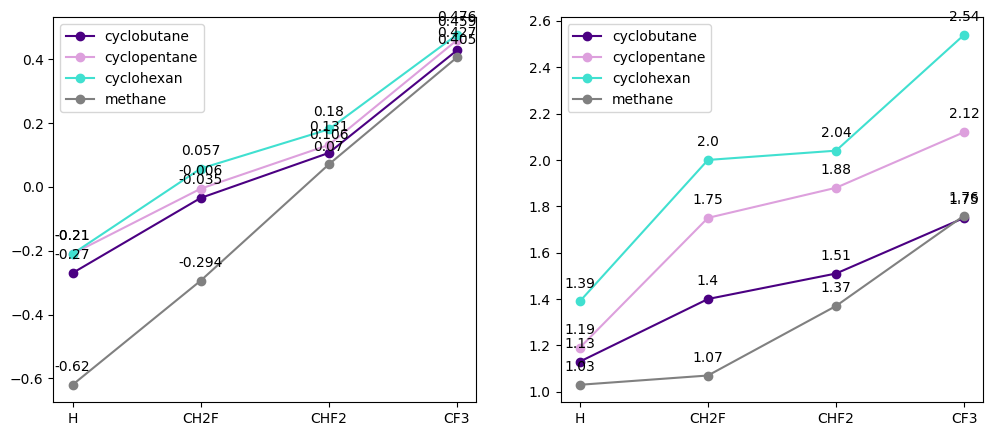

cyclobutane CHF O=C(c1ccccc1)N1CC(F)C1 0.94 -0.216
cyclobutane gem-CF2 O=C(c1ccccc1)N1CC(F)(F)C1 1.34 0.032
cyclopentane CHF O=C(c1ccccc1)N1CCC(F)C1 0.91 -0.265
cyclopentane gem-CF2 O=C(c1ccccc1)N1CCC(F)(F)C1 1.35 0.018
cyclopentane CHF O=C(c1ccccc1)N1C[C@@H](F)[C@@H](F)C1 1.01 -0.114
cyclopentane CHF O=C(c1ccccc1)N1C[C@@H](F)[C@H](F)C1 1.08 -0.131
cyclohexane CHF O=C(c1ccccc1)N1CCCC(F)C1 1.26 -0.171
cyclohexane gem-CF2 O=C(c1ccccc1)N1CCCC(F)(F)C1 1.65 0.018
cyclohexane CHF O=C(c1ccccc1)N1C[C@H](F)C[C@H](F)C1 0.58 -0.067
cyclohexane CHF O=C(c1ccccc1)N1C[C@@H](F)C[C@H](F)C1 1.35 0.179
cyclohexane CHF O=C(c1ccccc1)N1CC[C@@H](F)[C@@H](F)C1 1.15 -0.025
cyclohexane CHF O=C(c1ccccc1)N1CC[C@@H](F)[C@H](F)C1 1.26 -0.057
cyclohexane CF3 O=C(c1ccccc1)N1CCCC(C(F)(F)F)C1 2.21 0.497
cyclohexane CHF2 O=C(c1ccccc1)N1CCCC(C(F)F)C1 1.73 0.138
cyclohexane CH2F O=C(c1ccccc1)N1CCCC(CF)C1 1.52 -0.124
cyclopentane CF3 O=C(c1ccccc1)N1CCC(C(F)(F)F)C1 1.7 0.459
cyclopentane CHF2 O=C(c1ccccc1)N1CCC(C(F)F)C1 1.4

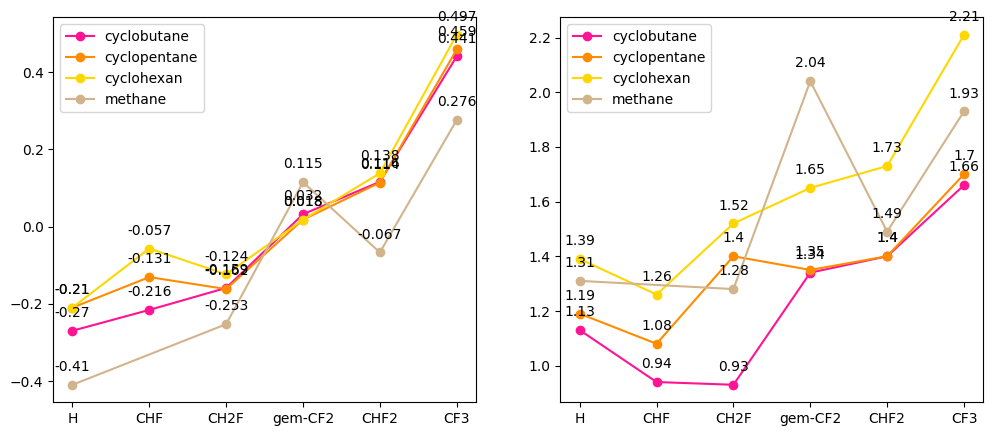

cyclohexane gem-CF2 O=C(c1ccccc1)N1CCC(F)(F)CC1 1.51 -0.008
cyclohexane CHF O=C(c1ccccc1)N1CCC(F)CC1 1.31 -0.127
cyclohexane CF3 O=C(c1ccccc1)N1CCC(C(F)(F)F)CC1 2.2 0.31
cyclohexane CHF2 O=C(c1ccccc1)N1CCC(C(F)F)CC1 1.67 0.013
cyclohexane CH2F O=C(c1ccccc1)N1CCC(CF)CC1 1.45 -0.125
methane CH2F O=C(NCCCCF)c1ccccc1 1.56 -0.138
methane CHF2 O=C(NCCCC(F)F)c1ccccc1 1.76 -0.083
methane CF3 O=C(NCCCC(F)(F)F)c1ccccc1 2.28 0.181
methane gem-CF2 CC(F)(F)CCNC(=O)c1ccccc1 1.81 -0.067
['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.21, -0.127, -0.125, -0.008, 0.013, 0.31] [1.39, 1.31, 1.45, 1.51, 1.67, 2.2]
['H', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.28, -0.138, -0.067, -0.083, 0.181] [1.72, 1.56, 1.81, 1.76, 2.28]


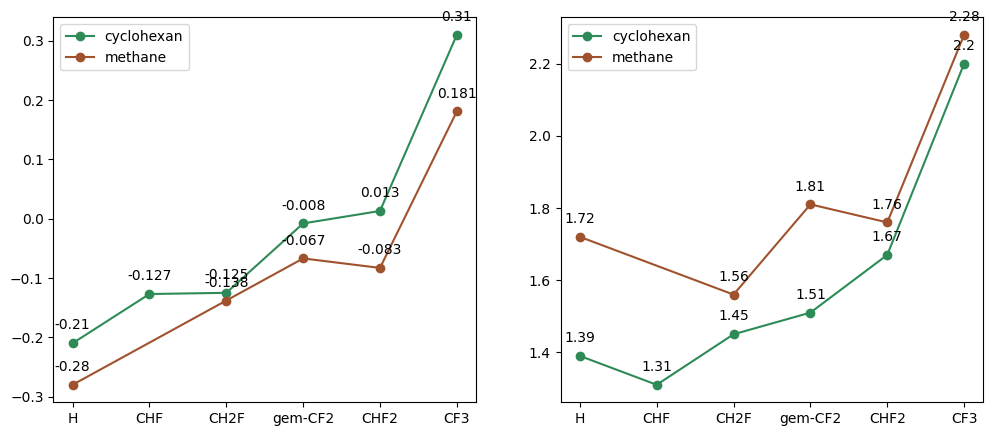

In [6]:
import matplotlib.pyplot as plt

cyclobutane_color = {1: 'indigo', 2: 'deeppink'}
cyclopentane_color = {1: 'plum', 2: 'darkorange'}
cyclohexan_color = {1: 'turquoise', 2: 'gold', 3: 'seagreen'}
methane_color = {1: 'grey', 2: 'tan', 3: 'sienna'}

cyclobutane_name = 'cyclobutane'
cyclopentane_name = 'cyclopentane'
cyclohexan_name = 'cyclohexan'
methane_name = 'methane'

cyclobutane_logP = {1: {'H': [1.13]}, 2: {'H': [1.13]}}
cyclopentane_logP = {1: {'H': [1.19]}, 2: {'H': [1.19]}}
cyclohexan_logP = {1: {'H': [1.39]}, 2: {'H': [1.39]}, 3: {'H': [1.39]}}
methane_logP = {1: {'H': [1.03], 'CF3': [1.76]}, 2: {'H': [1.31]}, 3: {'H': [1.72]}}

for distance_global in range(1, 4):
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))
    
    # X_optimal = ['H', 'CH2F', 'CHF2', 'CF3']
    X_optimal = ['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3']
    for SMILES, distance in smiles_to_distance_to_nitrogen.items():
        logP_value = SMILES_to_logP[SMILES]
    
        if distance != distance_global:
            continue
        
        if 'cyclohexane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in cyclohexan:
                cyclohexan[distance_global][f_group].append(relevances_fluorine[SMILES])
                cyclohexan_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                cyclohexan[distance_global][f_group] = [relevances_fluorine[SMILES]]
                cyclohexan_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            print("cyclohexane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])

        elif 'cyclopentane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in cyclopentane:
                cyclopentane[distance_global][f_group].append(relevances_fluorine[SMILES])
                cyclopentane_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                cyclopentane[distance_global][f_group] = [relevances_fluorine[SMILES]]
                cyclopentane_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            print("cyclopentane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])

        elif 'cyclobutane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in cyclobutane:
                cyclobutane[distance_global][f_group].append(relevances_fluorine[SMILES])
                cyclobutane_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                cyclobutane[distance_global][f_group] = [relevances_fluorine[SMILES]]
                cyclobutane_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            print("cyclobutane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])
        
        elif 'methane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group == 'non-F':
                continue
            if f_group in methane:
                methane[distance_global][f_group].append(relevances_fluorine[SMILES])
                methane_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                methane[distance_global][f_group] = [relevances_fluorine[SMILES]]
                methane_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            print("methane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])

    for molecule_group, color, label, logP_dict in [(cyclobutane, cyclobutane_color, cyclobutane_name, cyclobutane_logP), 
                                                    (cyclopentane, cyclopentane_color, cyclopentane_name, cyclopentane_logP), 
                                                    (cyclohexan, cyclohexan_color, cyclohexan_name, cyclohexan_logP), 
                                                    (methane, methane_color, methane_name, methane_logP)]:
        X, y_relevance, y_logP = [], [], []
        if distance_global not in molecule_group:
            continue
        
        for f_group_optimal in X_optimal:
            if f_group_optimal not in molecule_group[distance_global]:
                continue

            X.append(f_group_optimal)
            y_relevance.append(sum(molecule_group[distance_global][f_group_optimal]) / len(molecule_group[distance_global][f_group_optimal]))
            y_logP.append(sum(logP_dict[distance_global][f_group_optimal]) / len(logP_dict[distance_global][f_group_optimal]))

        print(X, y_relevance, y_logP)
        ax1.plot(X, y_relevance, marker='o', linestyle='-', color=color[distance_global], label=label)
        for i in range(len(X)):
            ax1.annotate(f"{str(y_relevance[i])}", (X[i], y_relevance[i]), xytext=(0, 10), textcoords='offset points', ha='center')
        ax1.legend()

        ax2.plot(X, y_logP, marker='o', linestyle='-', color=color[distance_global], label=label)
        for i in range(len(X)):
            ax2.annotate(f"{str(y_logP[i])}", (X[i], y_logP[i]), xytext=(0, 10), textcoords='offset points', ha='center')
        ax2.legend()

    plt.show()
    
    


['H', 'CH2F', 'CHF2', 'CF3'] [-0.27, -0.035, 0.106, 0.427]
['H', 'CH2F', 'CHF2', 'CF3'] [-0.21, -0.006, 0.131, 0.459]
['H', 'CH2F', 'CHF2', 'CF3'] [-0.21, 0.057, 0.18, 0.476]
['H', 'CH2F', 'CHF2', 'CF3'] [-0.62, -0.294, 0.07, 0.405]
['H', 'CH2F', 'CHF2', 'CF3'] [[-0.27, -0.21, -0.21, -0.62], [-0.035, -0.006, 0.057, -0.294], [0.106, 0.131, 0.18, 0.07], [0.427, 0.459, 0.476, 0.405]]


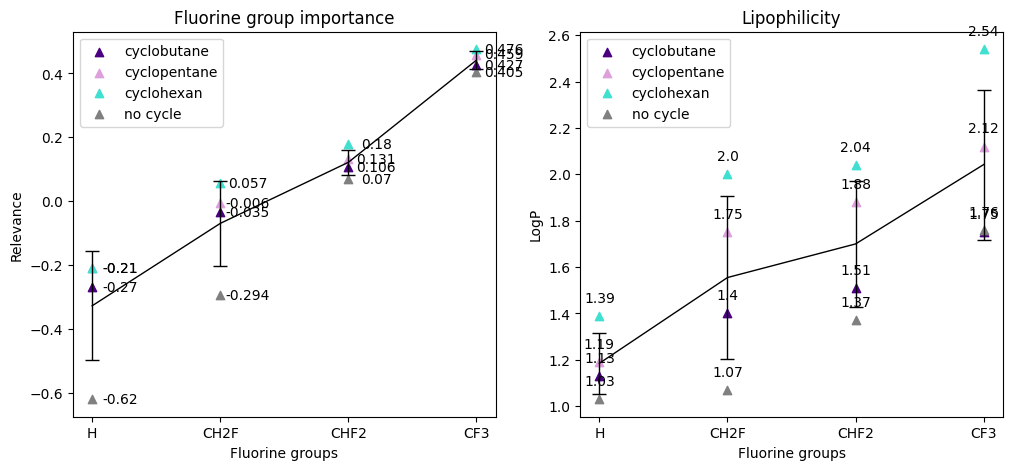

['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.27, -0.216, -0.159, 0.032, 0.116, 0.441]
['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.21, -0.131, -0.162, 0.018, 0.114, 0.459]
['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.21, -0.057, -0.124, 0.018, 0.138, 0.497]
['H', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.41, -0.253, 0.115, -0.067, 0.276]
['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [[-0.27, -0.21, -0.21, -0.41], [-0.216, -0.131, -0.057], [-0.159, -0.162, -0.124, -0.253], [0.032, 0.018, 0.018, 0.115], [0.116, 0.114, 0.138, -0.067], [0.441, 0.459, 0.497, 0.276]]


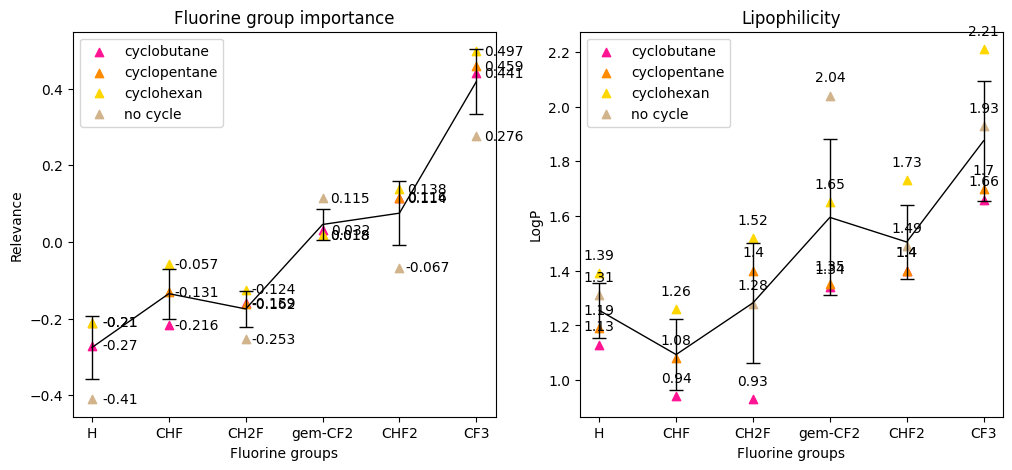

['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.21, -0.127, -0.125, -0.008, 0.013, 0.31]
['H', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [-0.28, -0.138, -0.067, -0.083, 0.181]
['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3'] [[-0.21, -0.28], [-0.127], [-0.125, -0.138], [-0.008, -0.067], [0.013, -0.083], [0.31, 0.181]]


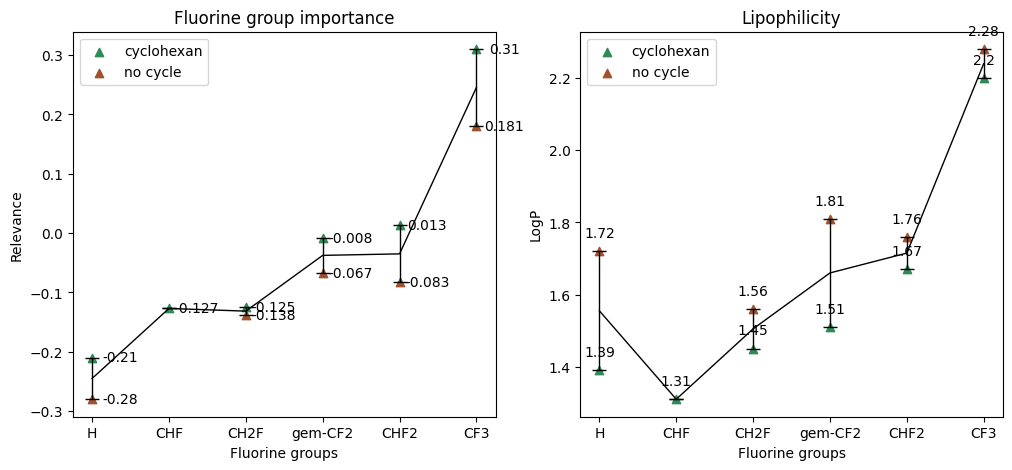

In [7]:
import matplotlib.pyplot as plt
import numpy as np

cyclobutane_color = {1: 'indigo', 2: 'deeppink'}
cyclopentane_color = {1: 'plum', 2: 'darkorange'}
cyclohexan_color = {1: 'turquoise', 2: 'gold', 3: 'seagreen'}
methane_color = {1: 'grey', 2: 'tan', 3: 'sienna'}

cyclobutane_name = 'cyclobutane'
cyclopentane_name = 'cyclopentane'
cyclohexan_name = 'cyclohexan'
methane_name = 'no cycle'

cyclobutane_logP = {1: {'H': [1.13]}, 2: {'H': [1.13]}}
cyclopentane_logP = {1: {'H': [1.19]}, 2: {'H': [1.19]}}
cyclohexan_logP = {1: {'H': [1.39]}, 2: {'H': [1.39]}, 3: {'H': [1.39]}}
methane_logP = {1: {'H': [1.03], 'CF3': [1.76]}, 2: {'H': [1.31]}, 3: {'H': [1.72]}}

for distance_global in range(1, 4):
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))
    
    # X_optimal = ['H', 'CH2F', 'CHF2', 'CF3']
    X_optimal = ['H', 'CHF', 'CH2F', 'gem-CF2', 'CHF2', 'CF3']
    for SMILES, distance in smiles_to_distance_to_nitrogen.items():
        logP_value = SMILES_to_logP[SMILES]
    
        if distance != distance_global:
            continue
        
        if 'cyclohexane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in cyclohexan:
                cyclohexan[distance_global][f_group].append(relevances_fluorine[SMILES])
                cyclohexan_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                cyclohexan[distance_global][f_group] = [relevances_fluorine[SMILES]]
                cyclohexan_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            # print("cyclohexane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])

        elif 'cyclopentane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in cyclopentane:
                cyclopentane[distance_global][f_group].append(relevances_fluorine[SMILES])
                cyclopentane_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                cyclopentane[distance_global][f_group] = [relevances_fluorine[SMILES]]
                cyclopentane_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            # print("cyclopentane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])

        elif 'cyclobutane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group in cyclobutane:
                cyclobutane[distance_global][f_group].append(relevances_fluorine[SMILES])
                cyclobutane_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                cyclobutane[distance_global][f_group] = [relevances_fluorine[SMILES]]
                cyclobutane_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            # print("cyclobutane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])
        
        elif 'methane' == SMILES_to_cycle_type[SMILES]:
            
            f_group = SMILES_to_fgroup[SMILES]
            if f_group == 'non-F':
                continue
            if f_group in methane:
                methane[distance_global][f_group].append(relevances_fluorine[SMILES])
                methane_logP[distance_global][f_group].append(SMILES_to_logP[SMILES])
            else:
                methane[distance_global][f_group] = [relevances_fluorine[SMILES]]
                methane_logP[distance_global][f_group] = [SMILES_to_logP[SMILES]]
            # print("methane", f_group, SMILES, logP_value, relevances_fluorine[SMILES])

    X, Y, Y_logP = [], [], []
    Y_dict = {f_group: [] for f_group in X_optimal}
    Y_logP_dict = {f_group: [] for f_group in X_optimal}
    for molecule_group, color, label, logP_dict in [(cyclobutane, cyclobutane_color, cyclobutane_name, cyclobutane_logP), 
                                                    (cyclopentane, cyclopentane_color, cyclopentane_name, cyclopentane_logP), 
                                                    (cyclohexan, cyclohexan_color, cyclohexan_name, cyclohexan_logP), 
                                                    (methane, methane_color, methane_name, methane_logP)
                                                    ]:
        y_relevance, y_logP, X_local = [], [], []
        if distance_global not in molecule_group:
            continue

        for f_group_optimal in X_optimal:
            if f_group_optimal not in molecule_group[distance_global]:
                continue
            X_local.append(f_group_optimal)

            Y_dict[f_group_optimal].append(sum(molecule_group[distance_global][f_group_optimal]) / len(molecule_group[distance_global][f_group_optimal]))
            y_relevance.append(sum(molecule_group[distance_global][f_group_optimal]) / len(molecule_group[distance_global][f_group_optimal]))
            Y_logP_dict[f_group_optimal].append(sum(logP_dict[distance_global][f_group_optimal]) / len(logP_dict[distance_global][f_group_optimal]))
            y_logP.append(sum(logP_dict[distance_global][f_group_optimal]) / len(logP_dict[distance_global][f_group_optimal]))

        print(X_local, y_relevance)
        ax1.scatter(X_local, y_relevance, marker='^', linestyle='-', color=color[distance_global], label=label)
        for i in range(len(X_local)):
            ax1.annotate(f"{str(y_relevance[i])}", (X_local[i], y_relevance[i]), xytext=(20, -3), textcoords='offset points', ha='center')
        ax1.legend()

        ax2.scatter(X_local, y_logP, marker='^', linestyle='-', color=color[distance_global], label=label)
        for i in range(len(X_local)):
            ax2.annotate(f"{str(y_logP[i])}", (X_local[i], y_logP[i]), xytext=(0, 10), textcoords='offset points', ha='center')
        ax2.legend()
    
    
    for f_group_name, relevances in Y_dict.items():
        if relevances != []:
            X.append(f_group_name)
            Y.append(relevances)
            Y_logP.append(Y_logP_dict[f_group_name])
    
    print(X, Y)
    mean_Y = [np.array(i).mean() for i in Y]
    std_deviation_Y = [np.array(i).std() for i in Y]
    
    ax1.plot(X, mean_Y, linestyle='-', color="black", label=label, linewidth=1)
    for i in range(len(X)):
        ax1.errorbar(X[i], mean_Y[i], yerr=std_deviation_Y[i], color='black', capsize=5, elinewidth=1, markeredgewidth=1)
    ax1.set_xlabel("Fluorine groups")
    ax1.set_ylabel("Relevance")
    ax1.set_title("Fluorine group importance")

    mean_logP_Y = [np.array(i).mean() for i in Y_logP]
    std_deviation_logP_Y = [np.array(i).std() for i in Y_logP]
    
    ax2.plot(X, mean_logP_Y, linestyle='-', color="black", label=label, linewidth=1)
    for i in range(len(X)):
        ax2.errorbar(X[i], mean_logP_Y[i], yerr=std_deviation_logP_Y[i], color='black', capsize=5, elinewidth=1, markeredgewidth=1)
    ax2.set_xlabel("Fluorine groups")
    ax2.set_ylabel("LogP")
    ax2.set_title("Lipophilicity")

    plt.show()
    
    
